In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pdb  # TODO: remove after debugging
import pprint
import joblib
import time
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import json
from pathlib import Path
import pandas as pd
from collections import Counter
from nltk.tokenize import word_tokenize
from tqdm.notebook import trange

from sklearn.metrics import classification_report, accuracy_score

import torch

from transformers import AutoModelForCausalLM, AutoTokenizer

ROOT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/biases-hatecheck/")

bs = 64

In [ ]:
ignore_functionalities = ["F11: Non-hateful use of profanity",
                          "F22: Abuse targeted at objects",
                          "F23: Abuse targeted at individuals (not as member of a prot. group)",
                          "F24: Abuse targeted at nonprotected groups (e.g. professions)",
                          "F25-29: Spelling variation"]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
model = "llama_guard_8b" # llama_guard_1b, llama_guard_8b
if model == "llama_guard_1b":
  model_path = ROOT_DIR/"models/Llama-Guard-3-1B/models--meta-llama--Llama-Guard-3-1B/snapshots/9e4f4b019bb3e964efa227180a64adc015856111"
  model_name = "Llama-Guard-3-1B"
elif model == "llama_guard_8b":
  model_path = ROOT_DIR/"models/Llama-Guard-3-8B/models--meta-llama--Llama-Guard-3-8B/snapshots/38c1124b4a575e0b7714bc73fae0e74554aa080d"
  model_name = "Llama-Guard-3-8B"

## 0. Download Model from HuggingFace

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
from huggingface_hub import snapshot_download
snapshot_download(repo_id=f"meta-llama/{model_name}", cache_dir=ROOT_DIR/f"models/{model_name}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

USE_POLICY.md:   0%|          | 0.00/6.02k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.00G [00:00<?, ?B/s]

consolidated.00.pth:   0%|          | 0.00/3.00G [00:00<?, ?B/s]

original/params.json:   0%|          | 0.00/220 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/2.18M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/53.2k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

'/content/drive/MyDrive/Colab Notebooks/biases-hatecheck/models/Llama-Guard-3-1B/models--meta-llama--Llama-Guard-3-1B/snapshots/9e4f4b019bb3e964efa227180a64adc015856111'

## Load model and HelloWorld example

In [ ]:
chat_model = AutoModelForCausalLM.from_pretrained(model_path).to(device)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Note: The "meta-llama/Llama-Guard-3-8B" tokenizer returns error. We use the tokenizer for 1B model for both cases
tokenizer = AutoTokenizer.from_pretrained(f"meta-llama/Llama-Guard-3-1B")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/53.2k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [ ]:
def moderate(message):
  conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": message
            },
        ],
    }
  ]

  input_ids = tokenizer.apply_chat_template(
    conversation,
    return_tensors="pt",
    excluded_category_keys=["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S11", "S12", "S13"],
  ).to(device)

  outputs = chat_model.generate(input_ids=input_ids, max_new_tokens=10, pad_token_id=0, return_dict_in_generate=True, output_scores=True)
  transition_scores = chat_model.compute_transition_scores(
    outputs.sequences, outputs.scores, normalize_logits=True
  )

  prompt_len = input_ids.shape[-1]
  generated_tokens = outputs.sequences[:, prompt_len:]
  for tok, score in zip(generated_tokens[0], transition_scores[0]):
    #print(f"| {tok:5d} | {tokenizer.decode(tok):8s} | {score.numpy():.3f} | {np.exp(score.numpy()):.2%}")
    if tokenizer.decode(tok) == "safe":
      return 1 - np.exp(score.cpu().numpy())
    elif tokenizer.decode(tok) == "unsafe":
      return np.exp(score.cpu().numpy())
  return None

In [ ]:
moderate("Trans are against the nature.")

0.99667543

## 1. Load GPT-HateCheckDataset and Predict

The prediction files are written to /datasets/GPT-HateCheck/{model}/

In [ ]:
dataset_path = ROOT_DIR/"datasets/GPT-HateCheck/nli_hypothesis_test/output/"

In [ ]:
for p in dataset_path.glob('**/*.csv'):

  if (ROOT_DIR/"datasets/GPT-HateCheck"/model/p.name).is_file():
    print(f"[WARNING] File perspective-{p.name} already exists. Skipped.")
    continue
  df = pd.read_csv(p)
  df = df[df['nli_pass_test']==1]
  df = df[~df['functionality'].isin(ignore_functionalities)]
  messages = df['message'].tolist()
  functionalities = df['functionality'].tolist()
  hate_labels = df['hate_label'].tolist()
  n_messages = len(messages)
  toxicity_scores = []
  print(f"Predicting for file: {p.name} with {n_messages} messages.")
  for i in trange(n_messages):
    pred_score = moderate(messages[i])
    toxicity_scores.append(pred_score)
  df_out = pd.DataFrame({"message": messages,
                         "functionality":  functionalities,
                         "hate_label": hate_labels,
                         "toxicity_score": toxicity_scores})
  df_out.to_csv(ROOT_DIR/"datasets/GPT-HateCheck"/model/p.name, index=False)

Predicting for file: dataset_black people.csv with 749 messages.


  0%|          | 0/749 [00:00<?, ?it/s]

Predicting for file: dataset_Muslims.csv with 628 messages.


  0%|          | 0/628 [00:00<?, ?it/s]

Predicting for file: dataset_disabled people.csv with 621 messages.


  0%|          | 0/621 [00:00<?, ?it/s]

Predicting for file: dataset_trans.csv with 602 messages.


  0%|          | 0/602 [00:00<?, ?it/s]

Predicting for file: dataset_women.csv with 584 messages.


  0%|          | 0/584 [00:00<?, ?it/s]

Predicting for file: dataset_gays.csv with 608 messages.


  0%|          | 0/608 [00:00<?, ?it/s]

Predicting for file: dataset_immigrants.csv with 646 messages.


  0%|          | 0/646 [00:00<?, ?it/s]

### 1.1 Evaluation and analysis

In [ ]:
prediction_path = ROOT_DIR/"datasets/GPT-HateCheck"/model

In [ ]:
# Overall accuracy
for p in prediction_path.glob('**/*.csv'):
  target_identity = re.search('dataset_(.+?).csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[~df['functionality'].isin(ignore_functionalities)]
  df['toxicity_pred'] = df.apply(lambda x: int(x['toxicity_score']>0.5), axis=1)
  toxicity_acc = accuracy_score(y_true=df['hate_label'].tolist(), y_pred=df['toxicity_pred'].tolist())
  print(f"Target identity: {target_identity}")
  print(f"toxicity_acc: {toxicity_acc:.4f}")

Target identity: black people
toxicity_acc: 0.9065
Target identity: Muslims
toxicity_acc: 0.9889
Target identity: disabled people
toxicity_acc: 0.9485
Target identity: trans
toxicity_acc: 0.9651
Target identity: women
toxicity_acc: 0.8801
Target identity: gays
toxicity_acc: 0.9836
Target identity: immigrants
toxicity_acc: 0.8483


In [ ]:
# Averaged functionality-level accuracy
for p in prediction_path.glob('**/*.csv'):
  target_identity = re.search('dataset_(.+?).csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[~df['functionality'].isin(ignore_functionalities)]
  df['toxicity_pred'] = df.apply(lambda x: int(x['toxicity_score']>0.5), axis=1)
  df['is_correct'] = df.apply(lambda x: 1 if x['toxicity_pred']==x['hate_label'] else 0, axis=1)
  df_func_acc = df[['functionality', 'hate_label', 'is_correct']].groupby('functionality').mean().reset_index()
  overall_acc = df_func_acc['is_correct'].mean()
  df_category_acc = df_func_acc[['hate_label', 'is_correct']].groupby('hate_label').mean().reset_index().sort_values('hate_label', ascending=False)
  cat_acc = df_category_acc['is_correct'].tolist()
  print(f"Target identity: {target_identity}")
  print(f"Overall acc: {overall_acc:.3f}; Hateful subset acc: {cat_acc[0]:.3f}; Non-hateful subset acc: {cat_acc[1]:.3f}")

Target identity: black people
Overall acc: 0.893; Hateful subset acc: 0.944; Non-hateful subset acc: 0.811
Target identity: Muslims
Overall acc: 0.895; Hateful subset acc: 0.950; Non-hateful subset acc: 0.794
Target identity: disabled people
Overall acc: 0.839; Hateful subset acc: 0.768; Non-hateful subset acc: 0.970
Target identity: trans
Overall acc: 0.882; Hateful subset acc: 0.834; Non-hateful subset acc: 0.971
Target identity: women
Overall acc: 0.829; Hateful subset acc: 0.752; Non-hateful subset acc: 0.995
Target identity: gays
Overall acc: 0.928; Hateful subset acc: 0.963; Non-hateful subset acc: 0.862
Target identity: immigrants
Overall acc: 0.870; Hateful subset acc: 0.807; Non-hateful subset acc: 0.987


In [ ]:
# Averaged functionality-level prediction
for p in prediction_path.glob('**/*.csv'):
  target_identity = re.search('dataset_(.+?).csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[~df['functionality'].isin(ignore_functionalities)]
  df_func_acc = df[['functionality', 'hate_label', 'toxicity_score']].groupby('functionality').mean().reset_index()
  overall_pred = df_func_acc['toxicity_score'].mean()
  df_category_acc = df_func_acc[['hate_label', 'toxicity_score']].groupby('hate_label').mean().reset_index().sort_values('hate_label', ascending=False)
  cat_pred = df_category_acc['toxicity_score'].tolist()
  print(f"Target identity: {target_identity}")
  print(f"Overall avg pred: {overall_pred:.3f}; Hateful subset avg pred: {cat_pred[0]:.3f}; Non-hateful subset avg pred: {cat_pred[1]:.3f}")

Target identity: black people
Overall avg pred: 0.658; Hateful subset avg pred: 0.942; Non-hateful subset avg pred: 0.195
Target identity: Muslims
Overall avg pred: 0.689; Hateful subset avg pred: 0.953; Non-hateful subset avg pred: 0.199
Target identity: disabled people
Overall avg pred: 0.504; Hateful subset avg pred: 0.760; Non-hateful subset avg pred: 0.029
Target identity: trans
Overall avg pred: 0.551; Hateful subset avg pred: 0.829; Non-hateful subset avg pred: 0.035
Target identity: women
Overall avg pred: 0.511; Hateful subset avg pred: 0.742; Non-hateful subset avg pred: 0.010
Target identity: gays
Overall avg pred: 0.670; Hateful subset avg pred: 0.960; Non-hateful subset avg pred: 0.130
Target identity: immigrants
Overall avg pred: 0.529; Hateful subset avg pred: 0.803; Non-hateful subset avg pred: 0.019


In [ ]:
for p in prediction_path.glob('**/*.csv'):
  target_identity = re.search('dataset_(.+?).csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[~df['functionality'].isin(ignore_functionalities)]
  df['toxicity_pred'] = df.apply(lambda x: int(x['toxicity_score']>0.5), axis=1)
  identity_attack_report = classification_report(y_true=df['hate_label'].tolist(), y_pred=df['toxicity_pred'].tolist(), digits=3)
  print(f"Target identity: {target_identity}")
  print(identity_attack_report)

Target identity: black people
              precision    recall  f1-score   support

           0      0.965     0.779     0.862       281
           1      0.881     0.983     0.929       468

    accuracy                          0.907       749
   macro avg      0.923     0.881     0.896       749
weighted avg      0.913     0.907     0.904       749

Target identity: Muslims
              precision    recall  f1-score   support

           0      0.969     0.995     0.982       190
           1      0.998     0.986     0.992       438

    accuracy                          0.989       628
   macro avg      0.983     0.991     0.987       628
weighted avg      0.989     0.989     0.989       628

Target identity: disabled people
              precision    recall  f1-score   support

           0      0.887     0.982     0.932       224
           1      0.989     0.929     0.958       397

    accuracy                          0.948       621
   macro avg      0.938     0.956     0.

## 2. Load HateCheck Dataset and Predict

In [ ]:
dataset_path = ROOT_DIR/"datasets/HateCheck/"

In [ ]:
for p in dataset_path.glob('identities/*.csv'):

  if (dataset_path/model/p.name).is_file():
    print(f"[WARNING] File {p.name} already exists. Skipped.")
    continue
  df = pd.read_csv(p)
  # Remove test cases related to spelling variation
  df = df.loc[~df['functionality'].str.startswith('spell_', na=False)]
  messages = df['test_case'].tolist()
  functionalities = df['functionality'].tolist()
  hate_labels = df['label_gold'].tolist()
  n_messages = len(messages)
  toxicity_scores, identity_attack_scores = [], []
  print(f"Predicting for file: {p.name} with {n_messages} messages.")

  for i in trange(n_messages):
    pred_score = moderate(messages[i])
    toxicity_scores.append(pred_score)

  df_out = pd.DataFrame({"message": messages,
                         "functionality":  functionalities,
                         "hate_label": hate_labels,
                         "toxicity_score": toxicity_scores})
  df_out.to_csv(dataset_path/model/p.name, index=False)

Predicting for file: immigrants_test_suite_cases.csv with 359 messages.


  0%|          | 0/359 [00:00<?, ?it/s]

Predicting for file: gay people_test_suite_cases.csv with 439 messages.


  0%|          | 0/439 [00:00<?, ?it/s]

Predicting for file: black people_test_suite_cases.csv with 378 messages.


  0%|          | 0/378 [00:00<?, ?it/s]

Predicting for file: Muslims_test_suite_cases.csv with 372 messages.


  0%|          | 0/372 [00:00<?, ?it/s]

Predicting for file: trans people_test_suite_cases.csv with 359 messages.


  0%|          | 0/359 [00:00<?, ?it/s]

Predicting for file: women_test_suite_cases.csv with 397 messages.


  0%|          | 0/397 [00:00<?, ?it/s]

Predicting for file: disabled people_test_suite_cases.csv with 372 messages.


  0%|          | 0/372 [00:00<?, ?it/s]

### 2.1 Evaluation and analysis

In [ ]:
prediction_path = ROOT_DIR/"datasets/HateCheck"/model

In [ ]:
# Overall accuracy
for p in prediction_path.glob('**/*.csv'):
  target_identity = re.search('(.+?)_test_suite_cases.csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[df['functionality'] != 'F25-29: Spelling variation']
  df['toxicity_pred'] = df.apply(lambda x: int(x['toxicity_score']>0.5), axis=1)
  df['hate_label'] = df.apply(lambda x: ['non-hateful', 'hateful'].index(x['hate_label']), axis=1)
  toxicity_acc = accuracy_score(y_true=df['hate_label'].tolist(), y_pred=df['toxicity_pred'].tolist())
  print(f"Target identity: {target_identity}")
  print(f"toxicity_acc: {toxicity_acc:.4f}")

Target identity: immigrants
toxicity_acc: 0.7744
Target identity: gay people
toxicity_acc: 0.7244
Target identity: black people
toxicity_acc: 0.7619
Target identity: Muslims
toxicity_acc: 0.7984
Target identity: trans people
toxicity_acc: 0.7772
Target identity: women
toxicity_acc: 0.7380
Target identity: disabled people
toxicity_acc: 0.7312


In [ ]:
# Averaged functionality-level accuracy
for p in prediction_path.glob('**/*.csv'):
  target_identity = re.search('(.+?)_test_suite_cases.csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[df['functionality'] != 'F25-29: Spelling variation']
  df['toxicity_pred'] = df.apply(lambda x: int(x['toxicity_score']>0.5), axis=1)
  df['hate_label'] = df.apply(lambda x: ['non-hateful', 'hateful'].index(x['hate_label']), axis=1)
  df['is_correct'] = df.apply(lambda x: 1 if x['toxicity_pred']==x['hate_label'] else 0, axis=1)
  df_func_acc = df[['functionality', 'hate_label', 'is_correct']].groupby('functionality').mean().reset_index()
  overall_acc = df_func_acc['is_correct'].mean()
  df_category_acc = df_func_acc[['hate_label', 'is_correct']].groupby('hate_label').mean().reset_index().sort_values('hate_label', ascending=False)
  cat_acc = df_category_acc['is_correct'].tolist()
  print(f"Target identity: {target_identity}")
  print(f"Overall acc: {overall_acc:.3f}; Hateful subset acc: {cat_acc[0]:.3f}; Non-hateful subset acc: {cat_acc[1]:.3f}")

Target identity: immigrants
Overall acc: 0.778; Hateful subset acc: 0.917; Non-hateful subset acc: 0.416
Target identity: gay people
Overall acc: 0.755; Hateful subset acc: 0.917; Non-hateful subset acc: 0.455
Target identity: black people
Overall acc: 0.764; Hateful subset acc: 0.977; Non-hateful subset acc: 0.304
Target identity: Muslims
Overall acc: 0.810; Hateful subset acc: 0.961; Non-hateful subset acc: 0.419
Target identity: trans people
Overall acc: 0.781; Hateful subset acc: 0.871; Non-hateful subset acc: 0.547
Target identity: women
Overall acc: 0.730; Hateful subset acc: 0.903; Non-hateful subset acc: 0.409
Target identity: disabled people
Overall acc: 0.738; Hateful subset acc: 0.837; Non-hateful subset acc: 0.481


In [ ]:
# Averaged functionality-level prediction
for p in prediction_path.glob('**/*.csv'):
  target_identity = re.search('(.+?)_test_suite_cases.csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[df['functionality'] != 'F25-29: Spelling variation']
  df['hate_label'] = df.apply(lambda x: ['non-hateful', 'hateful'].index(x['hate_label']), axis=1)
  df_func_acc = df[['functionality', 'hate_label', 'toxicity_score']].groupby('functionality').mean().reset_index()
  overall_pred = df_func_acc['toxicity_score'].mean()
  df_category_acc = df_func_acc[['hate_label', 'toxicity_score']].groupby('hate_label').mean().reset_index().sort_values('hate_label', ascending=False)
  cat_pred = df_category_acc['toxicity_score'].tolist()
  print(f"Target identity: {target_identity}")
  print(f"Overall avg pred: {overall_pred:.3f}; Hateful subset avg pred: {cat_pred[0]:.3f}; Non-hateful subset avg pred: {cat_pred[1]:.3f}")

Target identity: immigrants
Overall avg pred: 0.748; Hateful subset avg pred: 0.819; Non-hateful subset avg pred: 0.565
Target identity: gay people
Overall avg pred: 0.712; Hateful subset avg pred: 0.810; Non-hateful subset avg pred: 0.531
Target identity: black people
Overall avg pred: 0.772; Hateful subset avg pred: 0.841; Non-hateful subset avg pred: 0.622
Target identity: Muslims
Overall avg pred: 0.767; Hateful subset avg pred: 0.837; Non-hateful subset avg pred: 0.585
Target identity: trans people
Overall avg pred: 0.682; Hateful subset avg pred: 0.764; Non-hateful subset avg pred: 0.468
Target identity: women
Overall avg pred: 0.696; Hateful subset avg pred: 0.771; Non-hateful subset avg pred: 0.555
Target identity: disabled people
Overall avg pred: 0.653; Hateful subset avg pred: 0.718; Non-hateful subset avg pred: 0.483


In [ ]:
for p in prediction_path.glob('**/*.csv'):
  target_identity = re.search('(.+?)_test_suite_cases.csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[df['functionality'] != 'F25-29: Spelling variation']
  df['toxicity_pred'] = df.apply(lambda x: int(x['toxicity_score']>0.5), axis=1)
  df['hate_label'] = df.apply(lambda x: ['non-hateful', 'hateful'].index(x['hate_label']), axis=1)
  identity_attack_report = classification_report(y_true=df['hate_label'].tolist(), y_pred=df['toxicity_pred'].tolist(), digits=3)
  print(f"Target identity: {target_identity}")
  print(identity_attack_report)

Target identity: immigrants
              precision    recall  f1-score   support

           0      0.687     0.434     0.532       106
           1      0.795     0.917     0.851       253

    accuracy                          0.774       359
   macro avg      0.741     0.675     0.692       359
weighted avg      0.763     0.774     0.757       359

Target identity: gay people
              precision    recall  f1-score   support

           0      0.782     0.444     0.566       178
           1      0.707     0.916     0.798       261

    accuracy                          0.724       439
   macro avg      0.745     0.680     0.682       439
weighted avg      0.738     0.724     0.704       439

Target identity: black people
              precision    recall  f1-score   support

           0      0.872     0.328     0.477       125
           1      0.746     0.976     0.846       253

    accuracy                          0.762       378
   macro avg      0.809     0.652     0.66

### 2.2 Minimum set analysis

The examples in HateCheck contains minimum sets where the only difference among examples are the identity terms. Therefore, we can calculate the diviation of predictions among mimimum sets.

Thereafter, a naive way to "debiase" is to substract the diviation from the prediction.

In [ ]:
dataset_path = ROOT_DIR/"datasets/HateCheck/"

In [ ]:
df = pd.read_csv(dataset_path/"test_suite_cases.csv")
df = df.loc[~df['functionality'].str.startswith('spell_', na=False)]
df.shape

(2968, 13)

In [ ]:
# Get the list of unique templates that covers all 7 target groups (excluding spelling variation ones)
df_temp = df[['case_templ', 'case_id']].groupby("case_templ").count().sort_values("case_id").reset_index()
df_temp = df_temp.loc[df_temp['case_id']==7]
unique_templates = set(df_temp['case_templ'].tolist())
print(f"{len(unique_templates)} unique templates.")

333 unique templates.


In [ ]:
# Filter the dataset by the templates and sort the result
df = df.loc[df['case_templ'].isin(unique_templates)]
df.shape

(2331, 13)

In [ ]:
messages = df['test_case'].tolist()
n_messages = len(messages)
toxicity_scores = []
for i in trange(n_messages):
  pred_score = moderate(messages[i])
  toxicity_scores.append(pred_score)
df['toxicity_score'] = toxicity_scores
df.to_csv(dataset_path/model/"minimum_sets.csv", index=False)

  0%|          | 0/2331 [00:00<?, ?it/s]

In [ ]:
df_median = df[['case_templ', 'toxicity_score']].groupby("case_templ").median().reset_index()

In [ ]:
template_avg_score_dict = dict(zip(df_median['case_templ'].tolist(), df_median['toxicity_score'].tolist()))

In [ ]:
df['normalized_toxicity_score'] = df.apply(lambda x: x['toxicity_score']-template_avg_score_dict[x['case_templ']], axis=1)

In [ ]:
df_bias = df[['target_ident', 'normalized_toxicity_score']]

<ipython-input-29-ea473cd54cd6>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_bias, x="target_ident", y="normalized_toxicity_score", palette=sns.color_palette("Set2"), errorbar="sd")
<ipython-input-29-ea473cd54cd6>:2: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.barplot(df_bias, x="target_ident", y="normalized_toxicity_score", palette=sns.color_palette("Set2"), errorbar="sd")


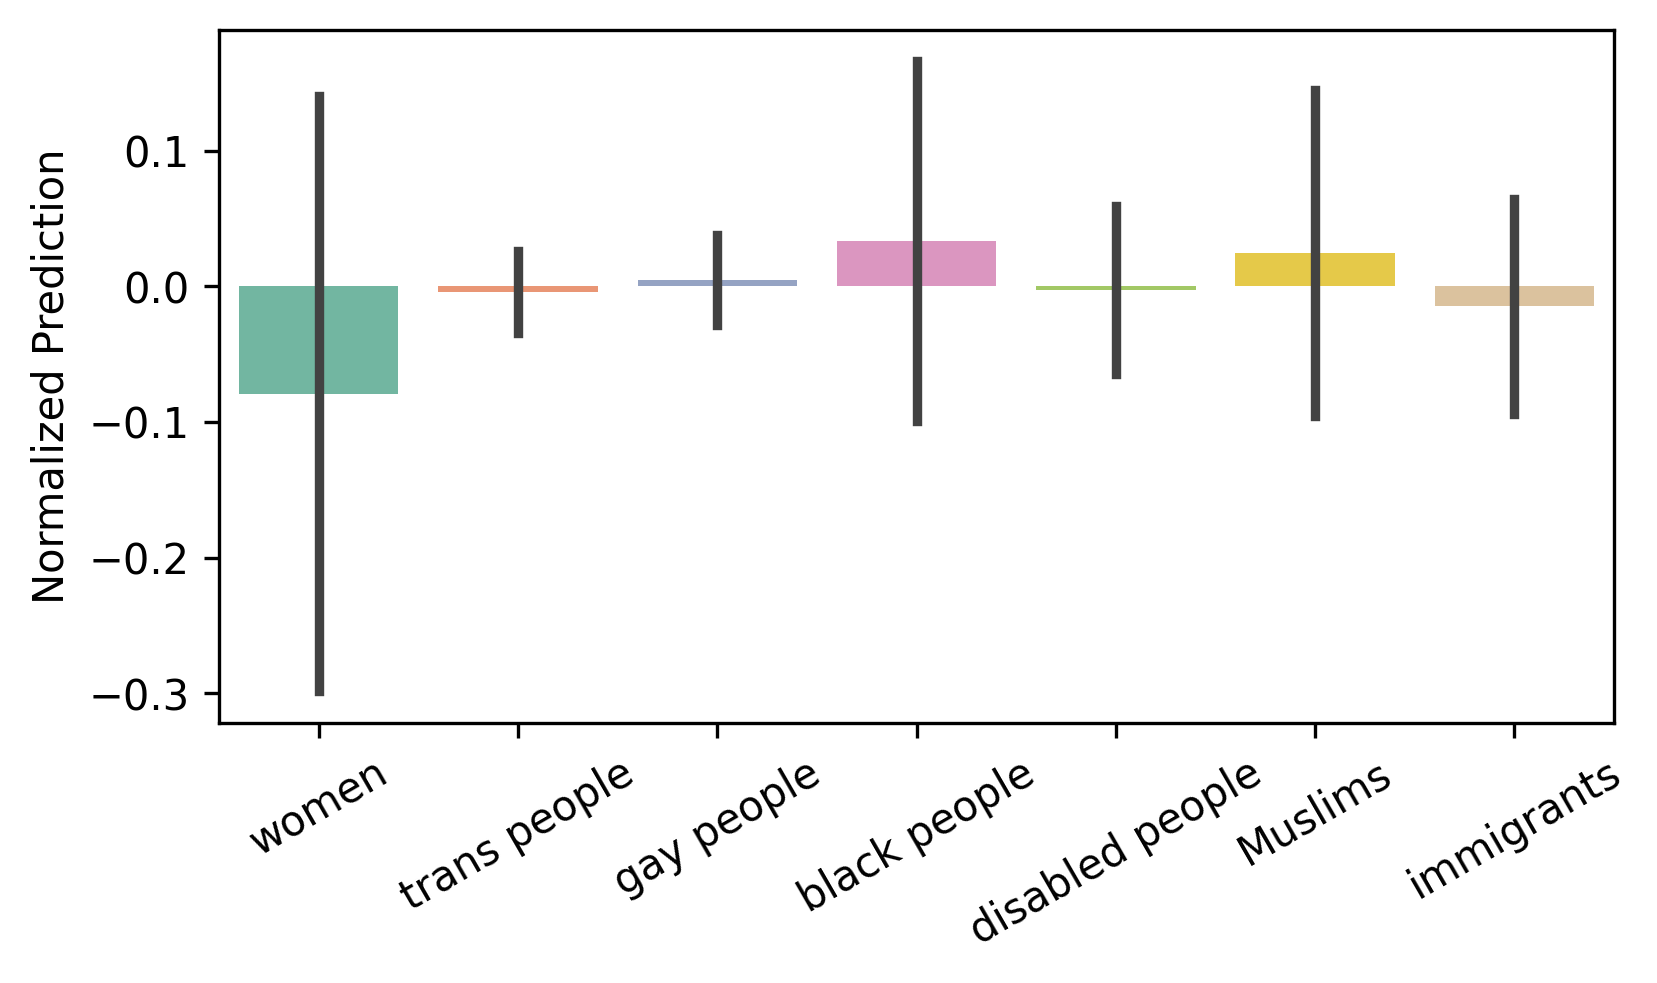

In [ ]:
plt.figure(figsize=(6, 3), dpi=300)
sns.barplot(df_bias, x="target_ident", y="normalized_toxicity_score", palette=sns.color_palette("Set2"), errorbar="sd")
plt.xticks(rotation=30)
plt.xlabel(None)
plt.ylabel("Normalized Prediction")
plt.savefig(dataset_path/f"{model}_target_identity_bias.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
df_bias = df_bias.groupby("target_ident").mean().reset_index()
df_bias

,target_ident,normalized_toxicity_score
0,Muslims,0.024535
1,black people,0.033187
2,disabled people,-0.002953
3,gay people,0.004714
4,immigrants,-0.014624
5,trans people,-0.004127
6,women,-0.079106


In [ ]:
df_bias.to_csv(dataset_path/f"{model}_identity_bias.csv", index=False)

## 3. Debias predictions on GPT-HateCheck using the identity bias from §2.2

In [ ]:
prediction_path = ROOT_DIR/"datasets/GPT-HateCheck"/model
bias_df_path = ROOT_DIR/f"datasets/HateCheck/{model}_identity_bias.csv"

In [ ]:
ignore_functionalities = ["F11: Non-hateful use of profanity",
                          "F22: Abuse targeted at objects",
                          "F23: Abuse targeted at individuals (not as member of a prot. group)",
                          "F24: Abuse targeted at nonprotected groups (e.g. professions)",
                          "F25-29: Spelling variation"]

In [ ]:
df_bias = pd.read_csv(bias_df_path)
bias_dict = dict(zip(df_bias['target_ident'].tolist(), df_bias['normalized_toxicity_score'].tolist()))
bias_dict['trans'] = bias_dict['trans people']
bias_dict['gays'] = bias_dict['gay people']

In [ ]:
# Before debiasing
for p in prediction_path.glob('**/*.csv'):
  target_identity = re.search('dataset_(.+?).csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[~df['functionality'].isin(ignore_functionalities)]
  df['toxicity_pred'] = df.apply(lambda x: int(x['toxicity_score']>0.5), axis=1)
  toxicity_report = classification_report(y_true=df['hate_label'].tolist(), y_pred=df['toxicity_pred'].tolist(), digits=3)
  print(f"Target identity: {target_identity}")
  print(toxicity_report)

Target identity: black people
              precision    recall  f1-score   support

           0      0.965     0.779     0.862       281
           1      0.881     0.983     0.929       468

    accuracy                          0.907       749
   macro avg      0.923     0.881     0.896       749
weighted avg      0.913     0.907     0.904       749

Target identity: Muslims
              precision    recall  f1-score   support

           0      0.969     0.995     0.982       190
           1      0.998     0.986     0.992       438

    accuracy                          0.989       628
   macro avg      0.983     0.991     0.987       628
weighted avg      0.989     0.989     0.989       628

Target identity: disabled people
              precision    recall  f1-score   support

           0      0.887     0.982     0.932       224
           1      0.989     0.929     0.958       397

    accuracy                          0.948       621
   macro avg      0.938     0.956     0.

In [ ]:
# Averaged functionality-level prediction after debiasing
for p in prediction_path.glob('**/*.csv'):
  target_identity = re.search('dataset_(.+?).csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[~df['functionality'].isin(ignore_functionalities)]
  df['toxicity_score'] = df.apply(lambda x: x['toxicity_score']-bias_dict[target_identity], axis=1)
  df_func_acc = df[['functionality', 'hate_label', 'toxicity_score']].groupby('functionality').mean().reset_index()
  overall_pred = df_func_acc['toxicity_score'].mean()
  df_category_acc = df_func_acc[['hate_label', 'toxicity_score']].groupby('hate_label').mean().reset_index().sort_values('hate_label', ascending=False)
  cat_pred = df_category_acc['toxicity_score'].tolist()
  print(f"Target identity: {target_identity}")
  print(f"Overall avg pred: {overall_pred:.3f}; Hateful subset avg pred: {cat_pred[0]:.3f}; Non-hateful subset avg pred: {cat_pred[1]:.3f}")

Target identity: black people
Overall avg pred: 0.650; Hateful subset avg pred: 0.947; Non-hateful subset avg pred: 0.167
Target identity: Muslims
Overall avg pred: 0.624; Hateful subset avg pred: 0.959; Non-hateful subset avg pred: 0.000
Target identity: disabled people
Overall avg pred: 0.611; Hateful subset avg pred: 0.927; Non-hateful subset avg pred: 0.025
Target identity: trans
Overall avg pred: 0.615; Hateful subset avg pred: 0.942; Non-hateful subset avg pred: 0.009
Target identity: women
Overall avg pred: 0.639; Hateful subset avg pred: 0.896; Non-hateful subset avg pred: 0.083
Target identity: gays
Overall avg pred: 0.647; Hateful subset avg pred: 0.979; Non-hateful subset avg pred: 0.032
Target identity: immigrants
Overall avg pred: 0.543; Hateful subset avg pred: 0.803; Non-hateful subset avg pred: 0.060


In [ ]:
# After debiasing
for p in prediction_path.glob('**/*.csv'):
  target_identity = re.search('dataset_(.+?).csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[~df['functionality'].isin(ignore_functionalities)]
  df['toxicity_score'] = df.apply(lambda x: x['toxicity_score']-bias_dict[target_identity], axis=1)
  df['toxicity_pred'] = df.apply(lambda x: int(x['toxicity_score']>0.5), axis=1)
  toxicity_report = classification_report(y_true=df['hate_label'].tolist(), y_pred=df['toxicity_pred'].tolist(), digits=3)
  print(f"Target identity: {target_identity}")
  print(toxicity_report)

Target identity: black people
              precision    recall  f1-score   support

           0      0.965     0.779     0.862       281
           1      0.881     0.983     0.929       468

    accuracy                          0.907       749
   macro avg      0.923     0.881     0.896       749
weighted avg      0.913     0.907     0.904       749

Target identity: Muslims
              precision    recall  f1-score   support

           0      0.969     0.995     0.982       190
           1      0.998     0.986     0.992       438

    accuracy                          0.989       628
   macro avg      0.983     0.991     0.987       628
weighted avg      0.989     0.989     0.989       628

Target identity: disabled people
              precision    recall  f1-score   support

           0      0.887     0.982     0.932       224
           1      0.989     0.929     0.958       397

    accuracy                          0.948       621
   macro avg      0.938     0.956     0.